In [290]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

#Setup some test cases
%run testCases_v2.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [291]:
#one extra unit test....
def L_model_forward_test_case_2hidden():
    np.random.seed(6)
    X = np.random.randn(5, 4)
    W1 = np.random.randn(4, 5)
    b1 = np.random.randn(4, 1)
    W2 = np.random.randn(3, 4)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return X, parameters

In [292]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [293]:
#Load Training Data
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


y = [0], it's a 'non-cat' picture.


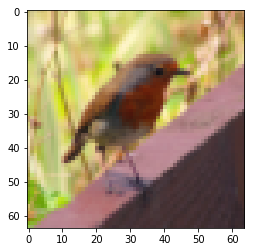

In [169]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [296]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

#standardize our dataset
#see lab 1 notes for more info
train_x = train_set_x_flatten/255
test_x = test_set_x_flatten/255

#Hack
train_y = train_set_y
test_y = test_set_y

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))


print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print (train_y.shape)
print (test_y.shape)

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]
train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
(1, 209)
(1, 50)


In [263]:
#debug data
#X
#training_set_inputs = np.array([[0, 0, 1], [1, 1, 1], [1, 0, 1], [0, 1, 1]]).T
training_set_inputs = np.array([[1, 1, 0]]).T
train_x = training_set_inputs

#Y
#training_set_outputs = np.array([[0, 1, 1, 0]])
training_set_outputs = np.array([[1]])
train_y = training_set_outputs


In [171]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h,1))
    W2 =  np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y,1))
    
    print ("the shape of w1 at init is" + str(W1.shape))
    print ("the shape of w2 at init is" + str(W2.shape))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters


In [172]:
#Unit Test for initialize_parameters
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

#Expected output
#W1 = [[ 0.01624345 -0.00611756 -0.00528172]
# [-0.01072969  0.00865408 -0.02301539]]
#b1 = [[0.]
# [0.]]
#W2 = [[ 0.01744812 -0.00761207]]
#b2 = [[0.]]


the shape of w1 at init is(2, 3)
the shape of w2 at init is(1, 2)
W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


In [297]:
def initialize_parameters_deep(layer_dims, debug = "N"):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
                
        if debug == "Y":
            parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        else:
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
                
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    #print (parameters)    
    return parameters

In [299]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]


In [230]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    #print (W.shape)
    #print (A.shape)
    ### START CODE HERE ### (≈ 1 line of code)
    Z = np.dot(W, A) + b
    ### END CODE HERE ###
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [231]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


In [305]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        ### END CODE HERE ###
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        ### START CODE HERE ### (≈ 2 lines of code)
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        ### END CODE HERE ###
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    
    #print ("activation= " + str(activation))
    #print ("W= " + str(W))
    #print ("b= " + str(b))
    #print ("Z= " + str(Z))
    #print ("A= " + str(A))
    return A, cache

In [269]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))


activation= sigmoid
W= [[ 0.50288142 -1.24528809 -1.05795222]]
b= [[-0.90900761]]
Z= [[ 3.43896131 -2.08938436]]
A= [[0.96890023 0.11013289]]
With sigmoid: A = [[0.96890023 0.11013289]]
activation= relu
W= [[ 0.50288142 -1.24528809 -1.05795222]]
b= [[-0.90900761]]
Z= [[ 3.43896131 -2.08938436]]
A= [[3.43896131 0.        ]]
With ReLU: A = [[3.43896131 0.        ]]


In [304]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        #print("The Layer is: " + str (l))
        
        A_prev = A 
        #print(A_prev.shape)
        ### START CODE HERE ### (≈ 2 lines of code)
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             activation='relu')
        caches.append(cache)
        ### END CODE HERE ###
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    ### START CODE HERE ### (≈ 2 lines of code)
    AL, cache =  linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    ### END CODE HERE ###
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [259]:
X, parameters = L_model_forward_test_case_2hidden()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

The Layer is: 1
Z= [[-5.23825714  3.18040136  0.4074501  -1.88612721]
 [-2.77358234 -0.56177316  3.18141623 -0.99209432]
 [ 4.18500916 -1.78006909 -0.14502619  2.72141638]
 [ 5.05850802 -1.25674082 -3.54566654  3.82321852]]
A= [[0.         3.18040136 0.4074501  0.        ]
 [0.         0.         3.18141623 0.        ]
 [4.18500916 0.         0.         2.72141638]
 [5.05850802 0.         0.         3.82321852]]
The Layer is: 2
Z= [[ 2.2644603   1.09971298 -2.90298027  1.54036335]
 [ 6.33722569 -2.38116246 -4.11228806  4.48582383]
 [10.37508342 -0.66591468  1.63635185  8.17870169]]
A= [[ 2.2644603   1.09971298  0.          1.54036335]
 [ 6.33722569  0.          0.          4.48582383]
 [10.37508342  0.          1.63635185  8.17870169]]
Z= [[-3.19864676  0.87117055 -1.40297864 -3.00319435]]
A= [[0.03921668 0.70498921 0.19734387 0.04728177]]
AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
Length of caches list = 3


In [181]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [226]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.41493159961539694


In [183]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    ### START CODE HERE ### (≈ 3 lines of code)
    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    ### END CODE HERE ###
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [184]:
# Set up some test inputs
dZ, linear_cache = linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


In [185]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
        
    elif activation == "sigmoid":
        ### START CODE HERE ### (≈ 2 lines of code)
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        ### END CODE HERE ###
    
    return dA_prev, dW, db

In [186]:
dAL, linear_activation_cache = linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "sigmoid")
print ("sigmoid:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(dAL, linear_activation_cache, activation = "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989 -0.        ]
 [ 0.37883606 -0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


In [187]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    ### START CODE HERE ### (1 line of code)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    ### END CODE HERE ###
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    ### START CODE HERE ### (approx. 2 lines)
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    ### END CODE HERE ###
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        ### START CODE HERE ### (approx. 5 lines)
        current_cache = caches[l]
        #print (l)
        #print (grads)
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        ### END CODE HERE ###

    return grads

In [188]:
AL, Y_assess, caches = L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print(grads)
######maybe wrong

{'dA1': array([[ 0.12913162, -0.44014127],
       [-0.14175655,  0.48317296],
       [ 0.01663708, -0.05670698]]), 'dW2': array([[-0.39202432, -0.13325855, -0.04601089]]), 'db2': array([[0.15187861]]), 'dA0': array([[ 0.        ,  0.52257901],
       [ 0.        , -0.3269206 ],
       [ 0.        , -0.32070404],
       [ 0.        , -0.74079187]]), 'dW1': array([[0.41010002, 0.07807203, 0.13798444, 0.10502167],
       [0.        , 0.        , 0.        , 0.        ],
       [0.05283652, 0.01005865, 0.01777766, 0.0135308 ]]), 'db1': array([[-0.22007063],
       [ 0.        ],
       [-0.02835349]])}


In [303]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
        #print("upate info begin")
        #print(grads["dW" + str(l+1)])  
        #print(learning_rate)
        #print (parameters["W" + str(l+1)])
        #print("upate info end")  
    
   # print ("begin parameters")
   # print (parameters)
   # print ("end parameters")
   # print ("begin grads")
   # print (grads)
   # print ("End grads")
    return parameters

In [284]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

upate info begin
[[ 1.78862847  0.43650985  0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898 -0.08274148 -0.62700068]
 [-0.04381817 -0.47721803 -1.31386475  0.88462238]]
0.1
[[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
upate info end
upate info begin
[[-0.40467741 -0.54535995 -1.54647732]]
0.1
[[-0.55569196  0.0354055   1.32964895]]
upate info end
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [191]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [192]:
def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [193]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [194]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [195]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [196]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 =  linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 =  linear_activation_backward(dA1, cache1, activation='relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

the shape of w1 at init is(7, 12288)
the shape of w2 at init is(1, 7)
Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203888
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.33942815383664127
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614843
Cost after iteration 1400: 0.19850735037466116
Cost after iteration 1500: 0.17448318112556627
Cost after iteration 1600: 0.17080762978096573
Cost after iteration 1700: 0.11306524562164724
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726863
Cost after ite

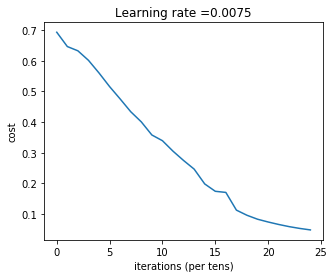

In [197]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [198]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [199]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [260]:
print (layers_dims)
print (parameters)

[3, 20, 7, 5, 1]
{'W1': array([[ 0.35480861,  1.81259031, -1.3564758 , -0.46363197,  0.82465384],
       [-1.17643148,  1.56448966,  0.71270509, -0.1810066 ,  0.53419953],
       [-0.58661296, -1.48185327,  0.85724762,  0.94309899,  0.11444143],
       [-0.02195668, -2.12714455, -0.83440747, -0.46550831,  0.23371059]]), 'b1': array([[ 1.38503523],
       [-0.51962709],
       [-0.78015214],
       [ 0.95560959]]), 'W2': array([[-0.12673638, -1.36861282,  1.21848065, -0.85750144],
       [-0.56147088, -1.0335199 ,  0.35877096,  1.07368134],
       [-0.37550472,  0.39636757, -0.47144628,  2.33660781]]), 'b2': array([[ 1.50278553],
       [-0.59545972],
       [ 0.52834106]]), 'W3': array([[ 0.9398248 ,  0.42628539, -0.75815703]]), 'b3': array([[-0.16236698]])}


In [210]:
print (layers_dims)
print (parameters["W1"].shape)
print (parameters["W2"].shape)
print (parameters["W3"].shape)
print (parameters["W4"].shape)

[12288, 20, 7, 5, 1]
(20, 12288)
(7, 20)
(5, 7)
(1, 5)


In [301]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims, debug = "N")
    #print (parameters)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        cost = compute_cost(AL, Y)
            
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693148
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


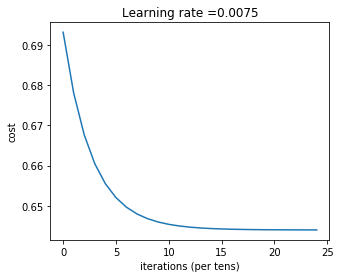

In [306]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
#layers_dims = [3, 20, 7, 5, 1] #  4-layer model

parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [162]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [163]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


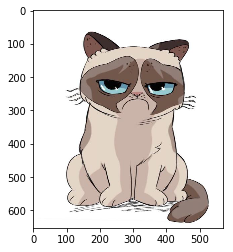

In [165]:
#test with custom image
my_image = "cartoon_grump.JPG" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "datasets/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")